In [11]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import xml.etree.ElementTree as ET
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

from sentence_transformers import SentenceTransformer, util
import torch
import seaborn as sns

import numpy as np

import utils as u
import os

plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "text.usetex": True  
    })


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
root_path = "./CSV"

In [13]:
df = pd.read_csv(os.path.join(root_path,"FP_v4.csv"), low_memory = False)

---
# 1st analyse

<Axes: title={'center': 'Distribution des scores climat'}, ylabel='Frequency'>

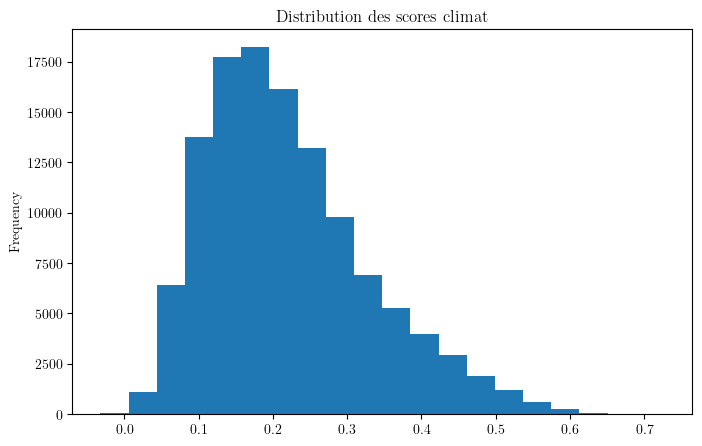

In [180]:
df['climate_score'] = pd.to_numeric(df['climate_score'], errors='coerce')

df['climate_score'].plot(kind='hist', bins=20, title="Distribution des scores climat", figsize=(8, 5))


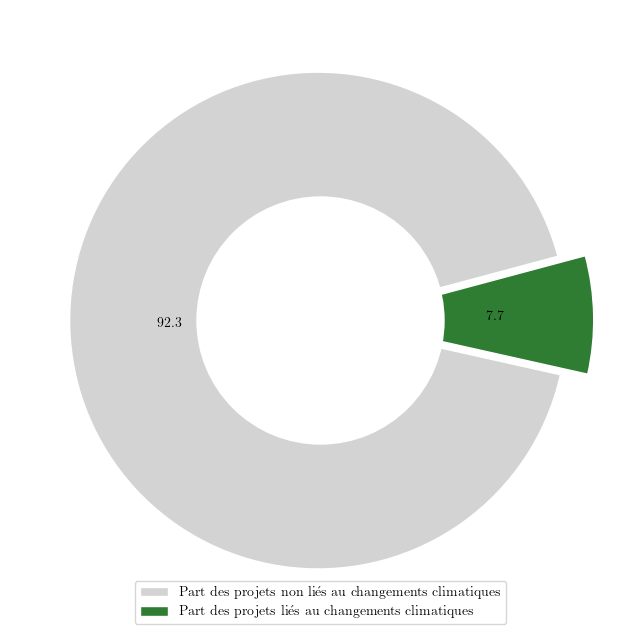

In [49]:
counts = df['is_climate_related'].value_counts().sort_index()
labels = ['Part des projets non liés au changements climatiques', 'Part des projets liés au changements climatiques']

colors = ['lightgray', '#2E7D32'] 

fig, ax = plt.subplots(figsize=(7,7))

wedges, texts, autotexts = ax.pie(
    counts,
    labels=['', ''],  # Pas de labels sur le graphique
    autopct='%1.1f%%',
    startangle=15,
    colors=colors,
    explode=(0.01, 0.1),
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
)

# Donut hole
centre_circle = plt.Circle((0,0), 0.5, color='white', fc='white', linewidth=0)
ax.add_artist(centre_circle)

# Légende avec les vrais labels
ax.legend(wedges, labels, loc='lower center')

plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.savefig("./exports/CC_projects_part_allDF.pdf")
plt.show()


frameworkProgramme
FP9    35105
FP7    25020
FP8    17181
FP5    11696
FP4    11149
FP6     9615
FP3     4073
FP2     3003
FP1     2620
Name: count, dtype: int64


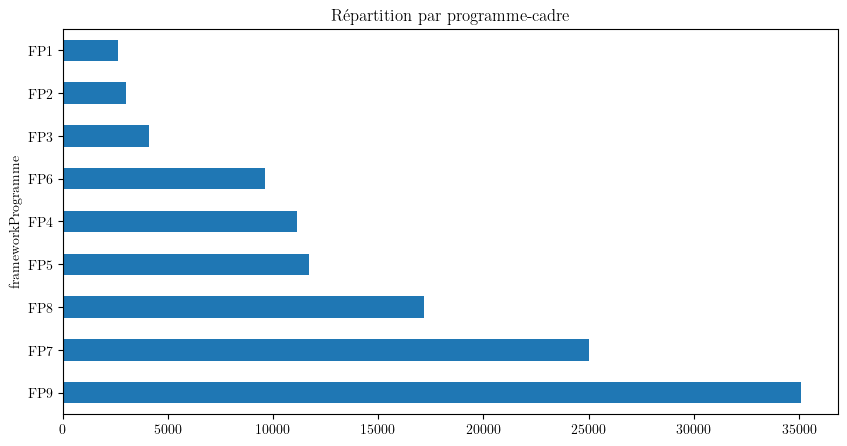

In [179]:
df['frameworkProgramme'].value_counts().plot(kind='barh', figsize=(10, 5), title="Répartition par programme-cadre")
print(df['frameworkProgramme'].value_counts())

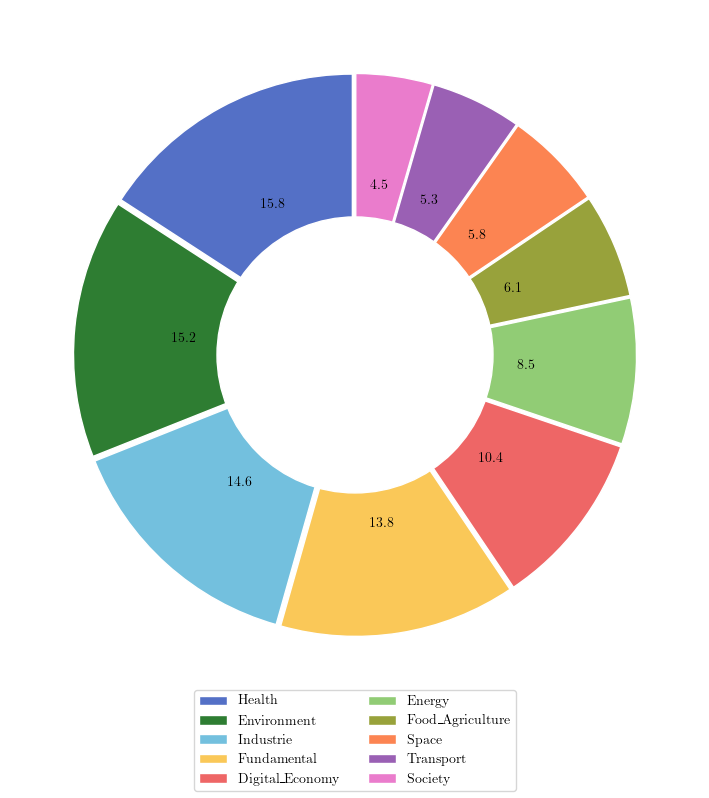

In [ ]:
counts = df['type_de_projet'].value_counts()
labels = counts.index.tolist()

# Construction des couleurs en utilisant le dictionnaire u.color_dict
colors = [u.color_dict.get(label, "#cccccc") for label in labels]  # gris clair par défaut si clé manquante

fig, ax = plt.subplots(figsize=(8,8))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f"{pct:.1f}% ({val})"
    return my_autopct

wedges, texts, autotexts = ax.pie(
    counts,
    labels=None,
    autopct=make_autopct(counts),
    startangle=90,
    colors=colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    explode=[0.02]*len(counts)
)

centre_circle = plt.Circle((0,0), 0.5, color='white')
ax.add_artist(centre_circle)

fig.legend(wedges, labels, loc='lower center', ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 1])
# plt.savefig("./exports/domain_repartition.pdf")

plt.show()


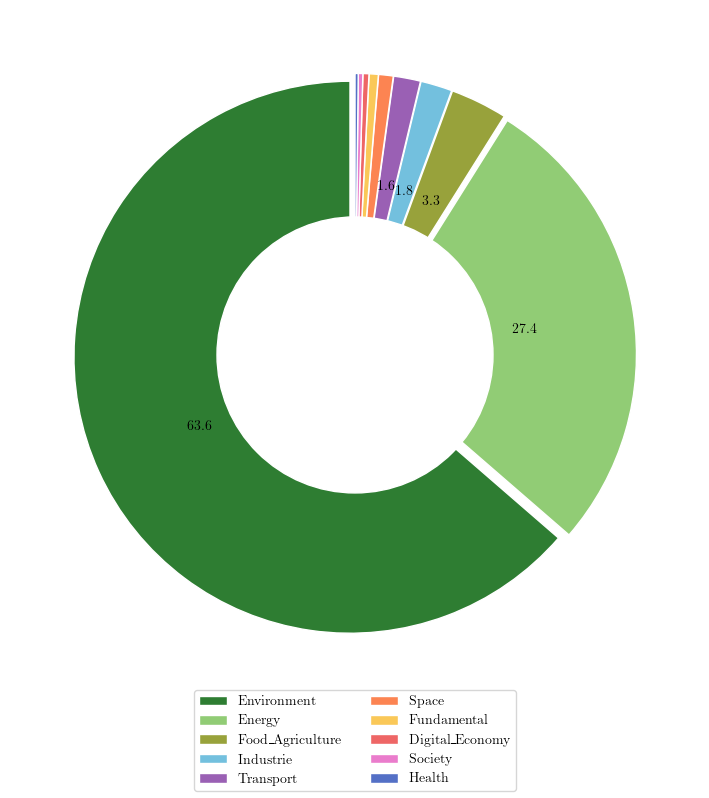

In [ ]:
# Filtrer les projets liés au climat
df_climate = df[df['is_climate_related']]

counts = df_climate['type_de_projet'].value_counts()
labels = counts.index.tolist()

# Utiliser le dictionnaire de couleurs défini dans utils.py
colors = [u.color_dict.get(label, "#cccccc") for label in labels]  # couleur par défaut si catégorie inconnue

fig, ax = plt.subplots(figsize=(8, 8))

# Liste des catégories pour lesquelles on affiche l'autopct
labels_to_show_pct = ["Environment", "Energy", "Food_Agriculture", "Industrie", "Transport"]

def make_autopct(values, labels_to_show):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        try:
            i = list(values).index(val)
        except ValueError:
            i = -1
        label = labels[i] if i >= 0 else None

        if label in labels_to_show:
            return f"{pct:.1f}% ({val})"
        else:
            return ""
    return my_autopct

wedges, texts, autotexts = ax.pie(
    counts,
    labels=None,
    autopct=make_autopct(counts, labels_to_show_pct),
    startangle=90,
    colors=colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    explode=[0.02] * len(counts)
)

# Cercle blanc au centre pour effet donut
centre_circle = plt.Circle((0, 0), 0.5, color='white')
ax.add_artist(centre_circle)

fig.legend(wedges, labels, loc='lower center', ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 1])
# plt.savefig("./exports/repartition_projets_climat_par_domaine.pdf")
plt.show()


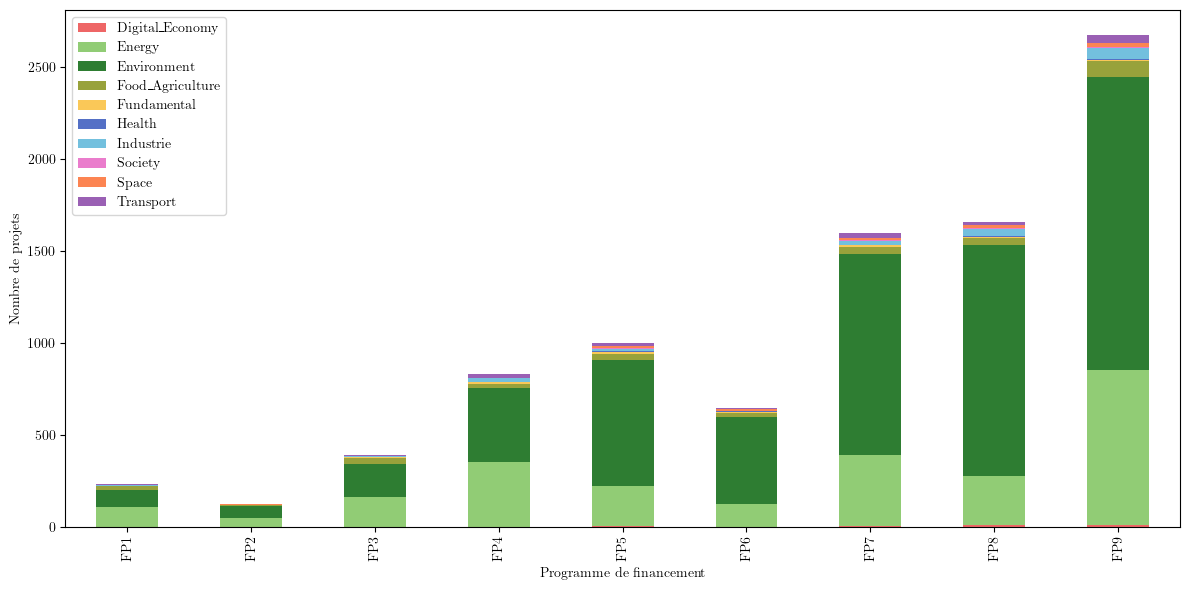

In [59]:
df_climate = df[df["is_climate_related"] == True]
df_count = df_climate.groupby(['frameworkProgramme', 'type_de_projet']).size().reset_index(name='count')
pivot_df = df_count.pivot(index='frameworkProgramme', columns='type_de_projet', values='count').fillna(0)

# Réorganiser les couleurs selon l'ordre des colonnes
ordered_labels = pivot_df.columns.tolist()
colors = [u.color_dict.get(label, "#cccccc") for label in ordered_labels]

pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.ylabel('Nombre de projets')
plt.xlabel('Programme de financement')
plt.legend()
plt.tight_layout()
# plt.savefig("./exports/project_number_by_domain_byFP.pdf")
plt.show()


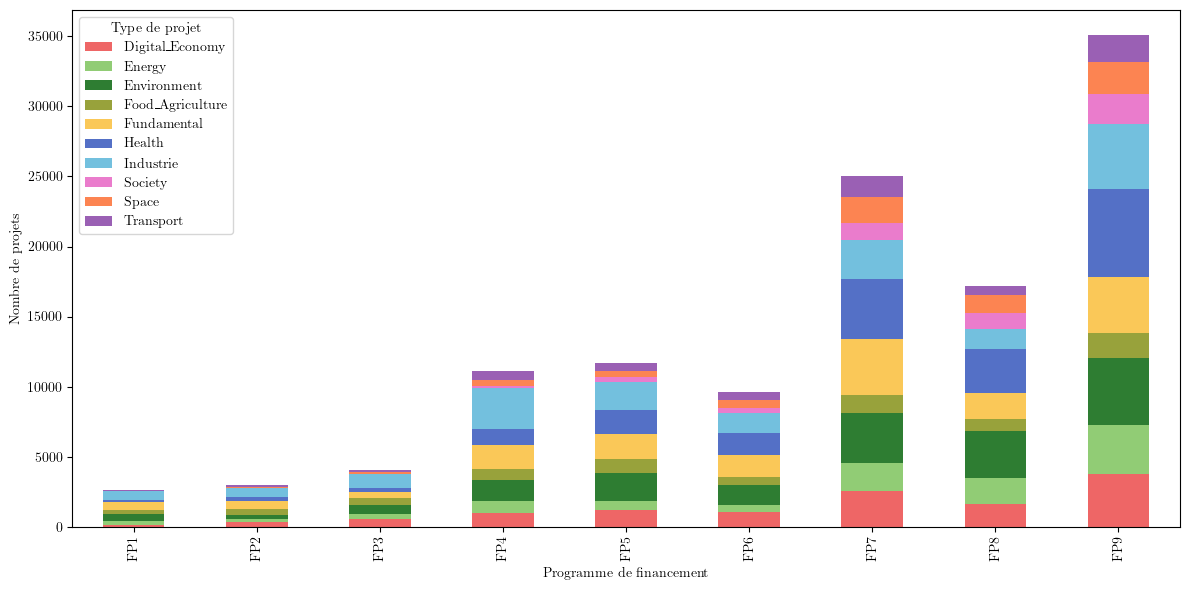

In [ ]:
df_count = df.groupby(['frameworkProgramme', 'type_de_projet']).size().reset_index(name='count')
pivot_df = df_count.pivot(index='frameworkProgramme', columns='type_de_projet', values='count').fillna(0)

# Réorganiser les couleurs selon l'ordre des colonnes
ordered_labels = pivot_df.columns.tolist()
colors = [u.color_dict.get(label, "#cccccc") for label in ordered_labels]

pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.ylabel('Nombre de projets')
plt.xlabel('Programme de financement')
plt.legend(title='Type de projet')
plt.tight_layout()
# plt.savefig("./exports/project_number_by_domain.pdf")
plt.show()


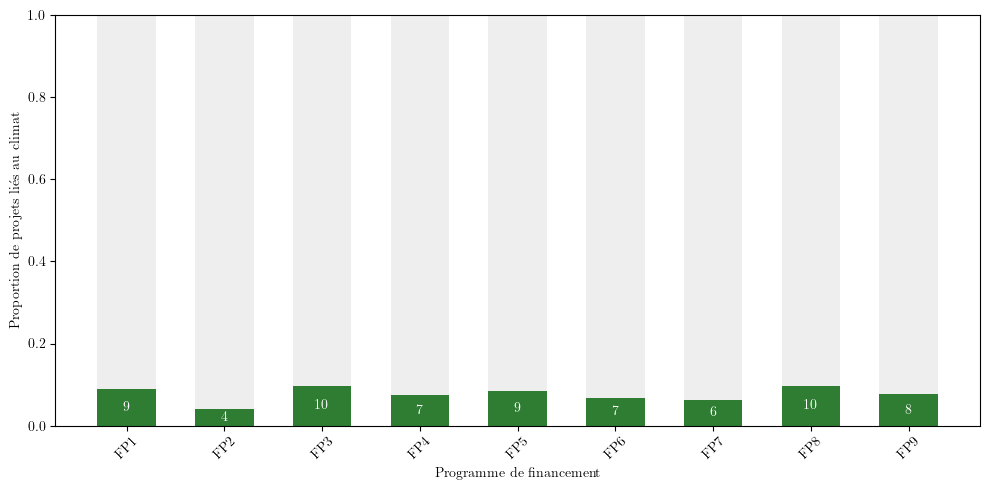

In [ ]:
climate_ratio = df.groupby("frameworkProgramme")["is_climate_related"].mean()

fig, ax = plt.subplots(figsize=(10, 5))
programmes = climate_ratio.index
ratios = climate_ratio.values
bar_width = 0.6
x = range(len(programmes))

ax.bar(x, [1]*len(ratios), color="#EEEEEE", width=bar_width, zorder=0)
bars = ax.bar(x, ratios, color="#2E7D32", width=bar_width, zorder=1)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        height / 2,  
        f"{height:.0%}", 
        ha='center', va='center', 
        color='white', fontsize=10, fontweight='bold'
    )

ax.set_ylabel("Proportion de projets liés au climat")
ax.set_xlabel("Programme de financement")
# ax.set_title("Évolution de la proportion de projets liés au changement climatique par programme")
ax.set_xticks(x)
ax.set_xticklabels(programmes, rotation=45)
ax.set_ylim(0, 1)
plt.tight_layout()
# plt.savefig("./exports/climate_proportion_by_fp.pdf")
plt.show()


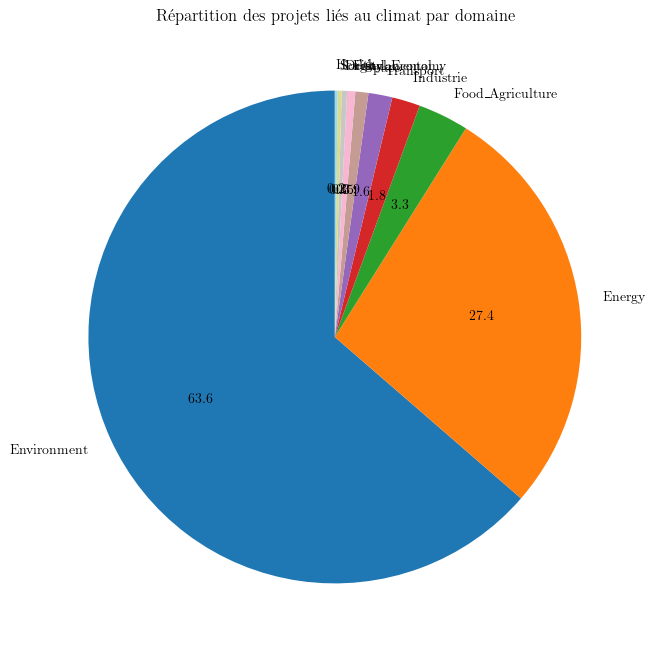

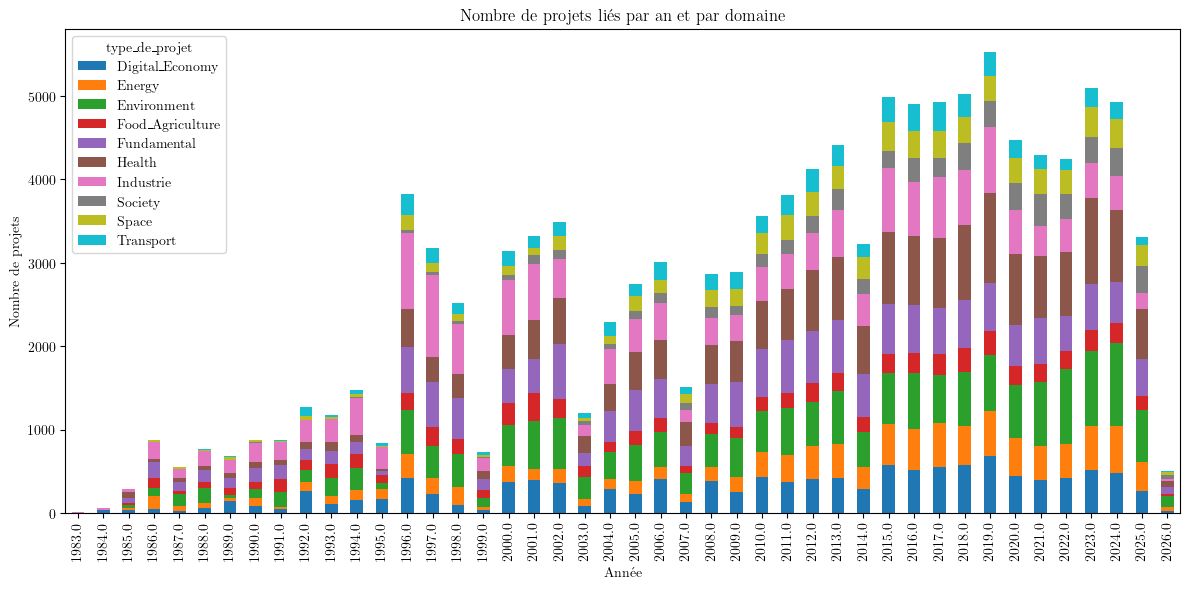

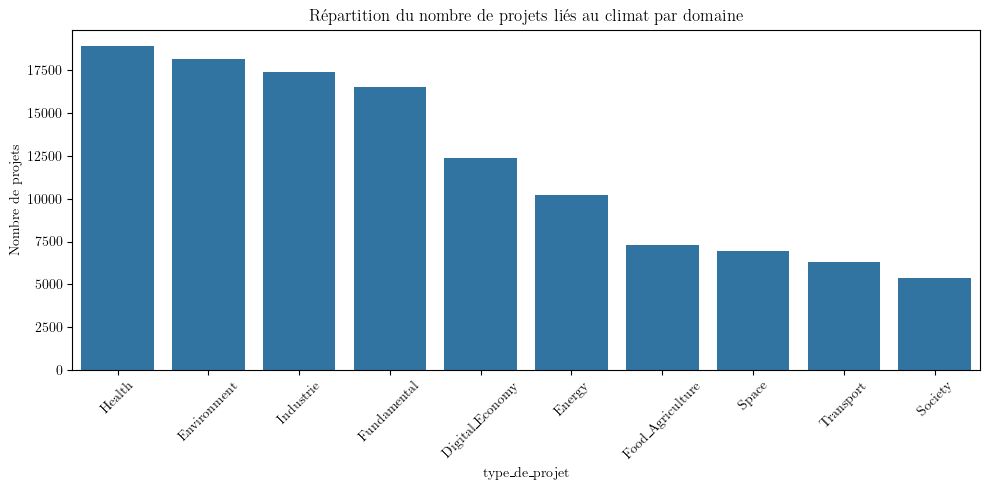

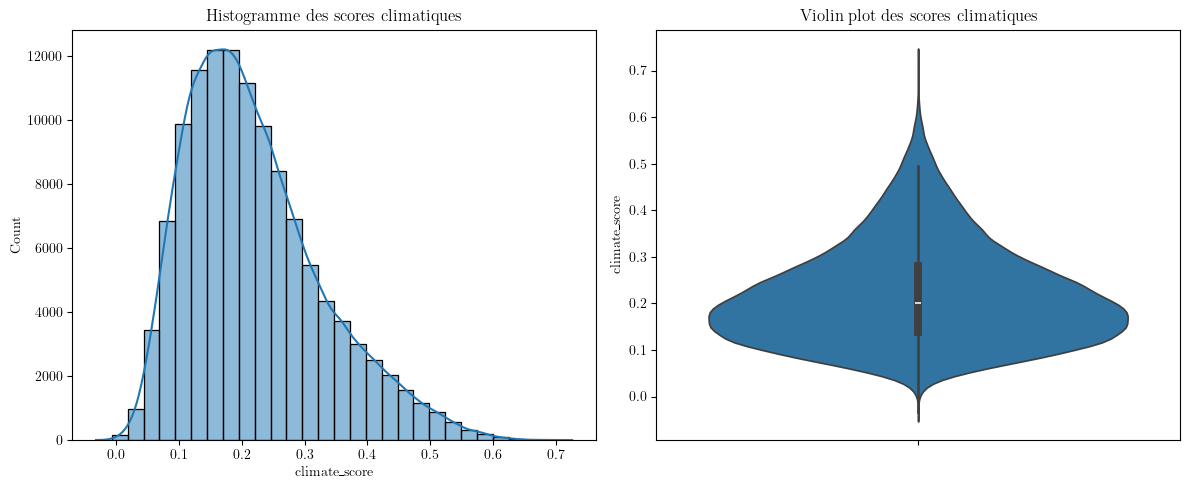

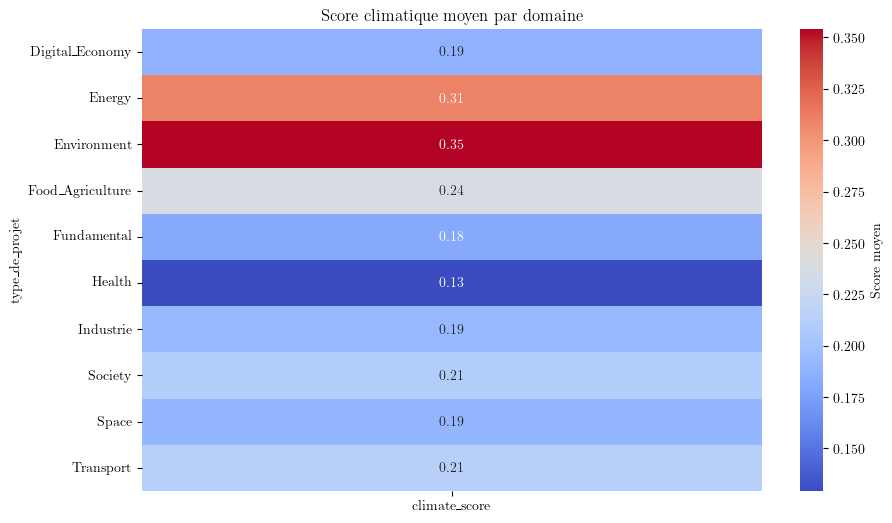

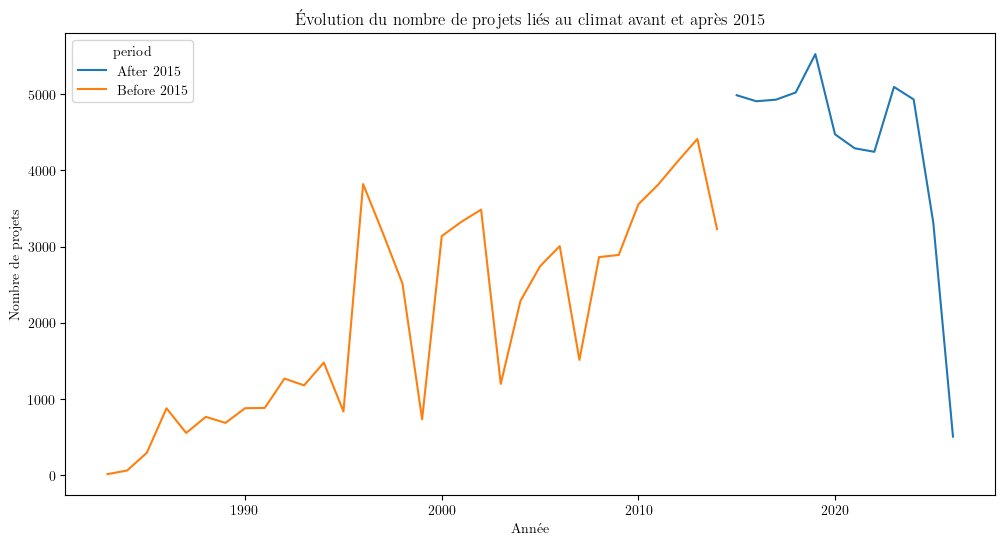

In [ ]:
df_climate = df[df['is_climate_related']]


# Compter le nombre de projets par domaine
counts = df_climate['type_de_projet'].value_counts()

# Afficher le camembert
plt.figure(figsize=(8,8))
counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='tab20')
plt.title("Répartition des projets liés au climat par domaine")
plt.ylabel('')  # Pour enlever le label y
plt.show()

# --- 1. Nombre de projets liés par an et par domaine (barres empilées) ---
df_count = df.groupby(['year', 'type_de_projet']).size().reset_index(name='count')
pivot_df = df_count.pivot(index='year', columns='type_de_projet', values='count').fillna(0)

pivot_df.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Nombre de projets liés par an et par domaine')
plt.ylabel('Nombre de projets')
plt.xlabel('Année')
plt.legend(title='type_de_projet')
plt.tight_layout()
plt.show()

# --- 2. Répartition globale des projets liés au climat par domaine (barres) ---
domain_counts = df['type_de_projet'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=domain_counts.index, y=domain_counts.values)
plt.title('Répartition du nombre de projets liés au climat par domaine')
plt.xticks(rotation=45)
plt.ylabel('Nombre de projets')
plt.tight_layout()
plt.show()

# --- 3. Distribution des scores “climate_score” (histogramme et violin) ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['climate_score'], bins=30, kde=True)
plt.title('Histogramme des scores climatiques')

plt.subplot(1,2,2)
sns.violinplot(y=df['climate_score'])
plt.title('Violin plot des scores climatiques')
plt.tight_layout()
plt.show()


mean_scores = df.groupby('type_de_projet')['climate_score'].mean().reset_index()
mean_scores_pivot = mean_scores.pivot_table(index='type_de_projet', values='climate_score')

plt.figure(figsize=(10,6))
sns.heatmap(mean_scores_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Score moyen'})
plt.title('Score climatique moyen par domaine')
plt.show()


df['period'] = df['year'].apply(lambda y: 'Before 2015' if y < 2015 else 'After 2015')
period_counts = df.groupby(['period', 'year']).size().reset_index(name='count')

plt.figure(figsize=(12,6))
sns.lineplot(data=period_counts, x='year', y='count', hue='period')
plt.title('Évolution du nombre de projets liés au climat avant et après 2015')
plt.ylabel('Nombre de projets')
plt.xlabel('Année')
plt.show()



In [187]:
summary = df.groupby("frameworkProgramme")["is_climate_related"].agg(
    total_projects='count',
    climate_related_projects='sum',
    proportion='mean'
)
print(summary)

                    total_projects  climate_related_projects  proportion
frameworkProgramme                                                      
FP1                           2620                       232    0.088550
FP2                           3003                       126    0.041958
FP3                           4073                       393    0.096489
FP4                          11149                       832    0.074626
FP5                          11696                      1001    0.085585
FP6                           9615                       649    0.067499
FP7                          25020                      1599    0.063909
FP8                          17181                      1655    0.096327
FP9                          35105                      2675    0.076200


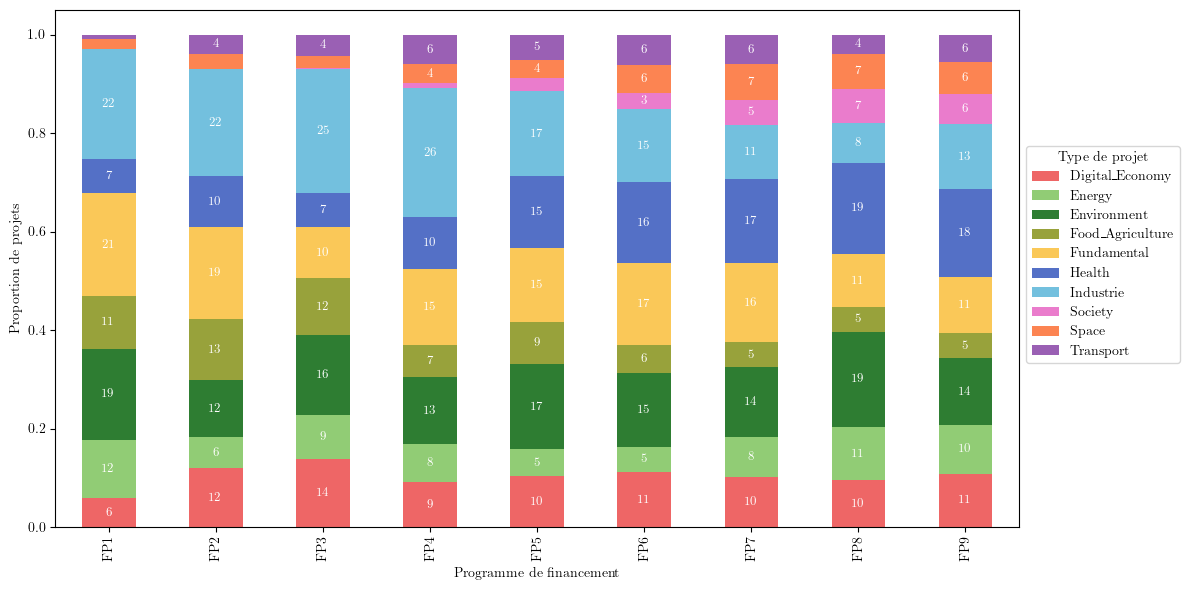

In [56]:
df_count = df.groupby(['frameworkProgramme', 'type_de_projet']).size().reset_index(name='count')
pivot_df = df_count.pivot(index='frameworkProgramme', columns='type_de_projet', values='count').fillna(0)

proportion_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
ordered_labels = proportion_df.columns.tolist()
colors = [u.color_dict.get(label, "#cccccc") for label in ordered_labels]

ax = proportion_df.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.ylabel('Proportion de projets')
plt.xlabel('Programme de financement')
plt.legend(title='Type de projet', bbox_to_anchor=(1., 0.75), loc='upper left')

for i, prog in enumerate(proportion_df.index):
    cum_sum = 0
    for j, col in enumerate(proportion_df.columns):
        val = proportion_df.loc[prog, col]
        if val > 0.03:  
            ax.text(i, cum_sum + val / 2, f"{val:.0%}", ha='center', va='center', color='white', fontsize=9)
        cum_sum += val

# plt.legend()
plt.tight_layout()
plt.savefig("./exports/repartition_domaine_byFP.pdf")
plt.show()


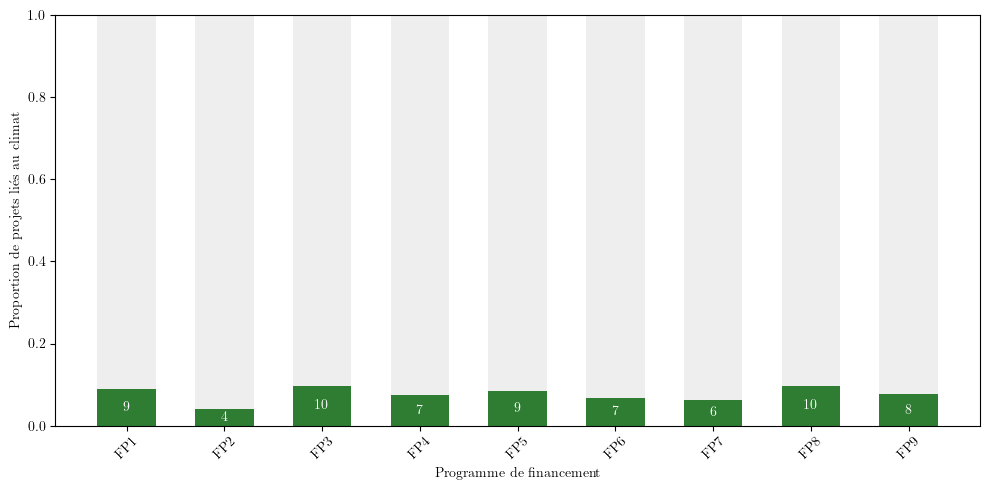

In [18]:
climate_ratio = df.groupby("frameworkProgramme")["is_climate_related"].mean()

fig, ax = plt.subplots(figsize=(10, 5))
programmes = climate_ratio.index
ratios = climate_ratio.values
bar_width = 0.6
x = range(len(programmes))

ax.bar(x, [1]*len(ratios), color="#EEEEEE", width=bar_width, zorder=0)
bars = ax.bar(x, ratios, color="#2E7D32", width=bar_width, zorder=1)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        height / 2,  
        f"{height:.0%}", 
        ha='center', va='center', 
        color='white', fontsize=10, fontweight='bold'
    )

ax.set_ylabel("Proportion de projets liés au climat")
ax.set_xlabel("Programme de financement")
# ax.set_title("Évolution de la proportion de projets liés au changement climatique par programme")
ax.set_xticks(x)
ax.set_xticklabels(programmes, rotation=45)
ax.set_ylim(0, 1)
plt.tight_layout()
# plt.savefig("./exports/climate_proportion_by_fp.pdf")
plt.show()


---
# 2nd in depth analyse

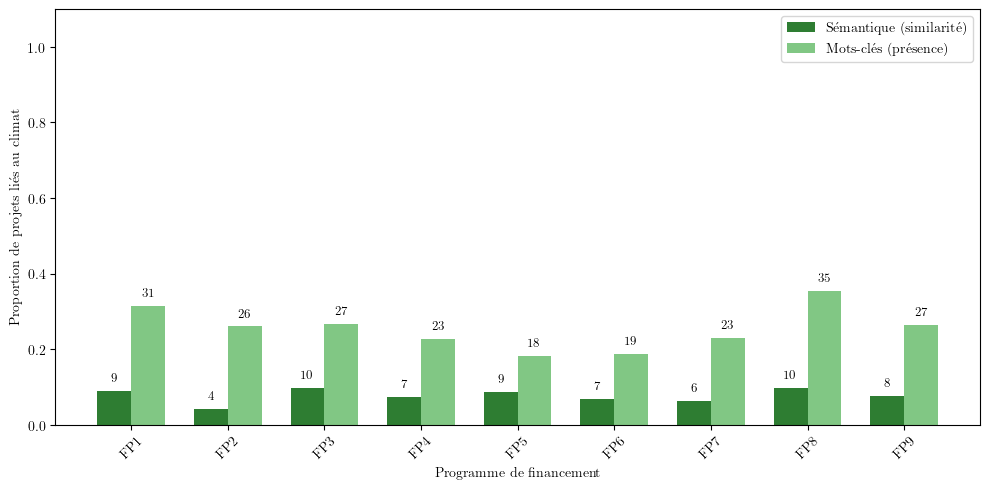

In [19]:
semantic_ratio = df.groupby("frameworkProgramme")["is_climate_related"].mean()
word_ratio = df.groupby("frameworkProgramme")["climate_word_realted"].mean()

fig, ax = plt.subplots(figsize=(10, 5))
programmes = semantic_ratio.index
x = np.arange(len(programmes))
bar_width = 0.35

bars1 = ax.bar(x - bar_width/2, semantic_ratio.values, width=bar_width, color="#2E7D32", label="Sémantique (similarité)")
bars2 = ax.bar(x + bar_width/2, word_ratio.values, width=bar_width, color="#81C784", label="Mots-clés (présence)")

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{height:.0%}",
            ha='center', va='bottom',
            fontsize=9
        )

ax.set_ylabel("Proportion de projets liés au climat")
ax.set_xlabel("Programme de financement")
ax.set_xticks(x)
ax.set_xticklabels(programmes, rotation=45)
ax.set_ylim(0, 1.1)
ax.legend()
plt.tight_layout()
plt.show()